In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from sqlalchemy import func


# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
# creating engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [12]:
# reflecting an existing database into a new model
Base = automap_base()

In [13]:
# reflecting the tables
Base.prepare(engine, reflect=True)

In [14]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Finding the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by((Measurement.date).desc()).first()
most_recent_date = datetime.strptime(most_recent_date[0], '%Y-%m-%d').date()

In [18]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results. 
# storing the 12 month offset from the m,ost recent date 
last_12 = most_recent_date + relativedelta(months=-12)


# Performing a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(func.strftime(Measurement.date) >= last_12).all()

In [19]:
# Save the query results as a Pandas DataFrame and setting the index to the date column
# creating columns for the dataframe
columns = ['date', 'precipitation']

# creating the dataframe
precipitation_df  = pd.DataFrame(columns = columns)

# cursing through the precipitation query and appending to the new precipitation dataframe
for data in query:
    precipitation_df = precipitation_df.append({
        'date' : pd.to_datetime(data[0]),
        'precipitation' : data[1]}, ignore_index = True)  

In [20]:
#setting the index on the date     
precipitation_df = precipitation_df.set_index('date')

In [21]:
# Sorting the dataframe by date and dropping all records that contain a null marker in the precipitation
precipitation_df = precipitation_df.sort_values('date').dropna()

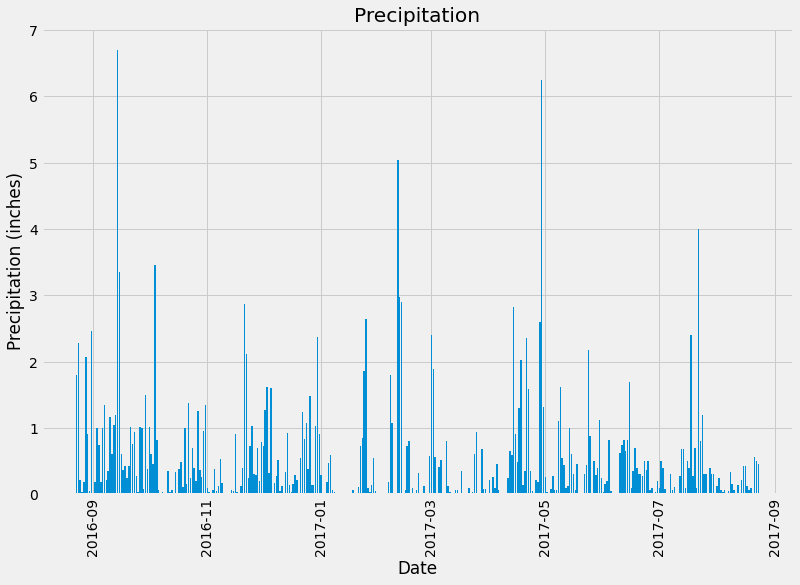

In [22]:
# Create figure to plot data
fig, ax = plt.subplots(figsize=(12, 8))

# Adding x-axis and y-axis
ax.bar(precipitation_df.index,
       precipitation_df['precipitation'])

# Seting title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title = 'Precipitation')

# Rotating tick marks on x-axis
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

In [23]:
# Using Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Designing a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).distinct().count()
print(f" There are a total of {total_stations} stations in the Stations table")  

 There are a total of 9 stations in the Stations table


In [25]:
# Designing a query to find the most active stations and listing the stations and the counts in descending order.
stations =  session.query(Station.station, Station.name, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                filter(Measurement.station == Station.station).\
                order_by(func.count(Measurement.station).desc()).all()

# printing stations and the counts
for i in stations:
    print(f" Station id: {i[0]}, Count: {i[2]}    name: {i[1]}")

 Station id: USC00519281, Count: 2772    name: WAIHEE 837.5, HI US
 Station id: USC00519397, Count: 2724    name: WAIKIKI 717.2, HI US
 Station id: USC00513117, Count: 2709    name: KANEOHE 838.1, HI US
 Station id: USC00519523, Count: 2669    name: WAIMANALO EXPERIMENTAL FARM, HI US
 Station id: USC00516128, Count: 2612    name: MANOA LYON ARBO 785.2, HI US
 Station id: USC00514830, Count: 2202    name: KUALOA RANCH HEADQUARTERS 886.9, HI US
 Station id: USC00511918, Count: 1979    name: HONOLULU OBSERVATORY 702.2, HI US
 Station id: USC00517948, Count: 1372    name: PEARL CITY, HI US
 Station id: USC00518838, Count: 511    name: UPPER WAHIAWA 874.3, HI US


In [ ]:
#id of highest avtive station
highest_active_id = stations[0][0]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(Measurement.station , func.min(Measurement.tobs)).\
                      group_by(Measurement.station).\
                      filter(Measurement.station == Station.station).\
                      filter(Station.station == highest_active_id).all()

highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
                       group_by(Measurement.station).\
                       filter(Measurement.station == Station.station).\
                       filter(Station.station == highest_active_id).all()

average_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
                       group_by(Measurement.station).\
                       filter(Measurement.station == Station.station).\
                       filter(Station.station == highest_active_id).all()

print(f"The lowest  temperature for the most active station is:  {round(lowest_temp[0][1],2)}")
print(f"The highest temperature for the most active station is:  {round(highest_temp[0][1],2)}")
print(f"The average temperature for the most active station is:  {round(average_temp[0][1],2)}")

The lowest  temperature for the most active station is:  54.0
The highest temperature for the most active station is:  85.0
The average temperature for the most active station is:  71.66


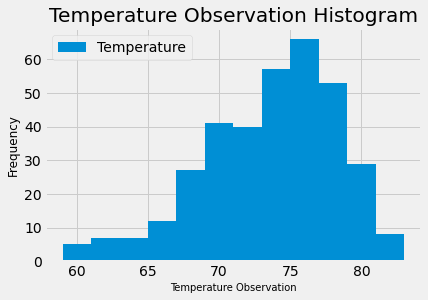

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram for the most active station
query = session.query(Measurement.date, Measurement.tobs).\
                filter(func.strftime(Measurement.date) >= last_12).\
                filter(Measurement.station == highest_active_id).all()

# creating columns for the dataframe
columns = ['date', 'temperature_observation']

# creating dataframe
temperature_df  = pd.DataFrame(columns = columns)

# cursing through the temperature observation query and appending to the new precipitation dataframe
for data in query:
    temperature_df = temperature_df.append({
                    'date' : pd.to_datetime(data[0]),
                    'temperature_observation' : data[1]}, ignore_index = True)  
#x axis    
x = temperature_df['temperature_observation']


# histogram title
plt.title('Temperature Observation Histogram')


# creating the label on the x axis 
plt.xlabel('Temperature Observation',  size=10)


# creating the label on the y axis 
plt.ylabel('Frequency', size=12)


# creating the histogram 
plt.hist(x, bins=12, label = "Temperature")


# adding the legend 
plt.legend()



plt.show()

In [41]:
#Closing Session
session.close()